In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams.update({'font.size': 16, 'xtick.major.width': 1, 'xtick.major.size': 2.5, 'ytick.major.width': 1, 'ytick.major.size': 2.5})
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
models = ["model1", "model2", "model3"]
sub_cohort = ['dbd_tier1_snvs', 'large_rare_deletions', 'large_rare_duplications', 'nejm_deletions', 'nejm_duplications']
pheno_cols = ['Full_scale_IQ', 'ABCL_CBCL_external', 'ABCL_CBCL_internal', 'SRS_raw', 'RBS_R', 'DCDQ', 'BMI_zscore']
variables = [
    ["SCZ_PRS", "All_rare_del_var"],
    ["SCZ_PRS", "Rare_Deleterious_SNVs", "`Genes DEL`", "`Genes DUP`", "`STRs exonic`"],
    ["SCZ_PRS", "Rare_Deleterious_SNVs_LOEUF", "`DELs LOEUF<0.35`", "`DUPs LOEUF<0.35`", "`STRs exonic LOEUF<0.35`"]
    ]

In [3]:
def read_stats(store_dir, m, s, pc, v):
    filename = os.path.join(store_dir, "_".join([m, s, pc, v]) + ".tsv").replace("`", "")
    df = pd.read_csv(filename, sep="\t")
    lor, pval, r2 = df.loc[df.Variable==v, ["Log Odds Ratio", "P-value", "R2"]].values.flatten()
    return lor, pval, r2


def make_dataframe(store_dir, m, s, pcs, vs):
    data_dict = {
        "phenotypes": [],
        "variables": [],
        "log odds ratio": [],
        "p value": [],
        "R2": []
    }

    for pc in pcs:
        all_model_file = os.path.join(store_dir, "_".join([m, s, pc + ".tsv"]))
        all_model_df = pd.read_csv(all_model_file, sep="\t")
        data_dict["phenotypes"].append(pc)
        data_dict["variables"].append("all")
        data_dict["log odds ratio"].append(np.nan)
        data_dict["p value"].append(np.nan)
        data_dict["R2"].append(all_model_df.loc[0, "R2"])

        for v in vs:
            lor, pval, r2 = read_stats(store_dir, m, s, pc, v)
            data_dict["phenotypes"].append(pc)
            data_dict["variables"].append(v)
            data_dict["log odds ratio"].append(lor)
            data_dict["p value"].append(pval)
            data_dict["R2"].append(r2)
    df = pd.DataFrame(data_dict)
    return df


def make_dataframe_all(store_dir, m, s, pcs):
    data_dict = {
        "phenotypes": [],
        "variables": [],
        "log odds ratio": [],
        "p value": [],
        "R2": []
    }

    for pc in pcs:
        all_model_file = os.path.join(store_dir, "_".join([m, s, pc + ".tsv"]))
        all_model_df = pd.read_csv(all_model_file, sep="\t")
        data_dict["phenotypes"].append(pc)
        data_dict["variables"].append(f"{m}-{s}")
        data_dict["log odds ratio"].append(np.nan)
        data_dict["p value"].append(np.nan)
        data_dict["R2"].append(all_model_df.loc[0, "R2"])

    df = pd.DataFrame(data_dict)
    return df

def make_heatmaps(store_dir, ms, scs, pcs, vs_list, save_file):
    fig, axes = plt.subplots(len(ms), len(scs), figsize=(60, 30))
    for i,(m, vs) in enumerate(zip(ms, vs_list)):
        for j,s in enumerate(scs):
            df = make_dataframe(store_dir, m, s, pcs, vs)
            plot_df = df.pivot(index="variables", columns="phenotypes", values="R2")
            annot_df = df.pivot(index="variables", columns="phenotypes", values="p value").fillna(1.)
            annot_df = (annot_df<0.05).replace({True: "*", False: ""})
            sns_ax = sns.heatmap(
                data=plot_df, 
                cmap="Reds",
                # annot=annot_df,
                # annot_kws={"fontsize": 24},
                fmt='',
                square=True,
                cbar_kws={"shrink": 1},
                ax=axes[i, j],
                vmin=0.,
                vmax=0.1,
                )
            sns_ax.set_xticklabels(sns_ax.get_xticklabels(), rotation=90, horizontalalignment='center')
            sns_ax.set_yticklabels(sns_ax.get_yticklabels(), rotation=0, horizontalalignment='right')
            sns_ax.set_title(f"{m}-{s}")
            sns_ax.set_xlabel("")
            sns_ax.set_ylabel("")
            ## color bar changes
            sns_ax.collections[0].colorbar.outline.set_visible(True)
            sns_ax.collections[0].colorbar.outline.set_color("black")
            sns_ax.collections[0].colorbar.outline.set_linewidth(1)

    pdf = PdfPages(save_file)
    pdf.savefig(fig, bbox_inches='tight')
    pdf.close()
    return


def make_heatmaps_all(store_dir, ms, scs, pcs, save_file):
    fig, axes = plt.subplots(1, 1, figsize=(12, 10))
    plot_df = pd.DataFrame()
    for i,m in enumerate(ms):
        for j,s in enumerate(scs):
            df = make_dataframe_all(store_dir, m, s, pcs)
            plot_df = pd.concat((plot_df, df), axis=0)

    plot_df = plot_df.pivot(index="variables", columns="phenotypes", values="R2")
    sns_ax = sns.heatmap(
        data=plot_df, 
        cmap="Reds",
        fmt='',
        square=True,
        cbar_kws={"shrink": 0.85, },
        ax=axes,
        vmin=0.,
        vmax=0.1,
        )
    sns_ax.set_xticklabels(sns_ax.get_xticklabels(), rotation=90, horizontalalignment='center')
    sns_ax.set_yticklabels(sns_ax.get_yticklabels(), rotation=0, horizontalalignment='right')
    sns_ax.set_title(f"All models variance explained")
    sns_ax.set_xlabel("")
    sns_ax.set_ylabel("")
    ## color bar changes
    sns_ax.collections[0].colorbar.outline.set_visible(True)
    sns_ax.collections[0].colorbar.outline.set_color("black")
    sns_ax.collections[0].colorbar.outline.set_linewidth(1)
    # sns_ax.collections[0].colorbar.ax.set_frame_on(True)

    pdf = PdfPages(save_file)
    pdf.savefig(fig, bbox_inches='tight')
    pdf.close()
    return sns_ax

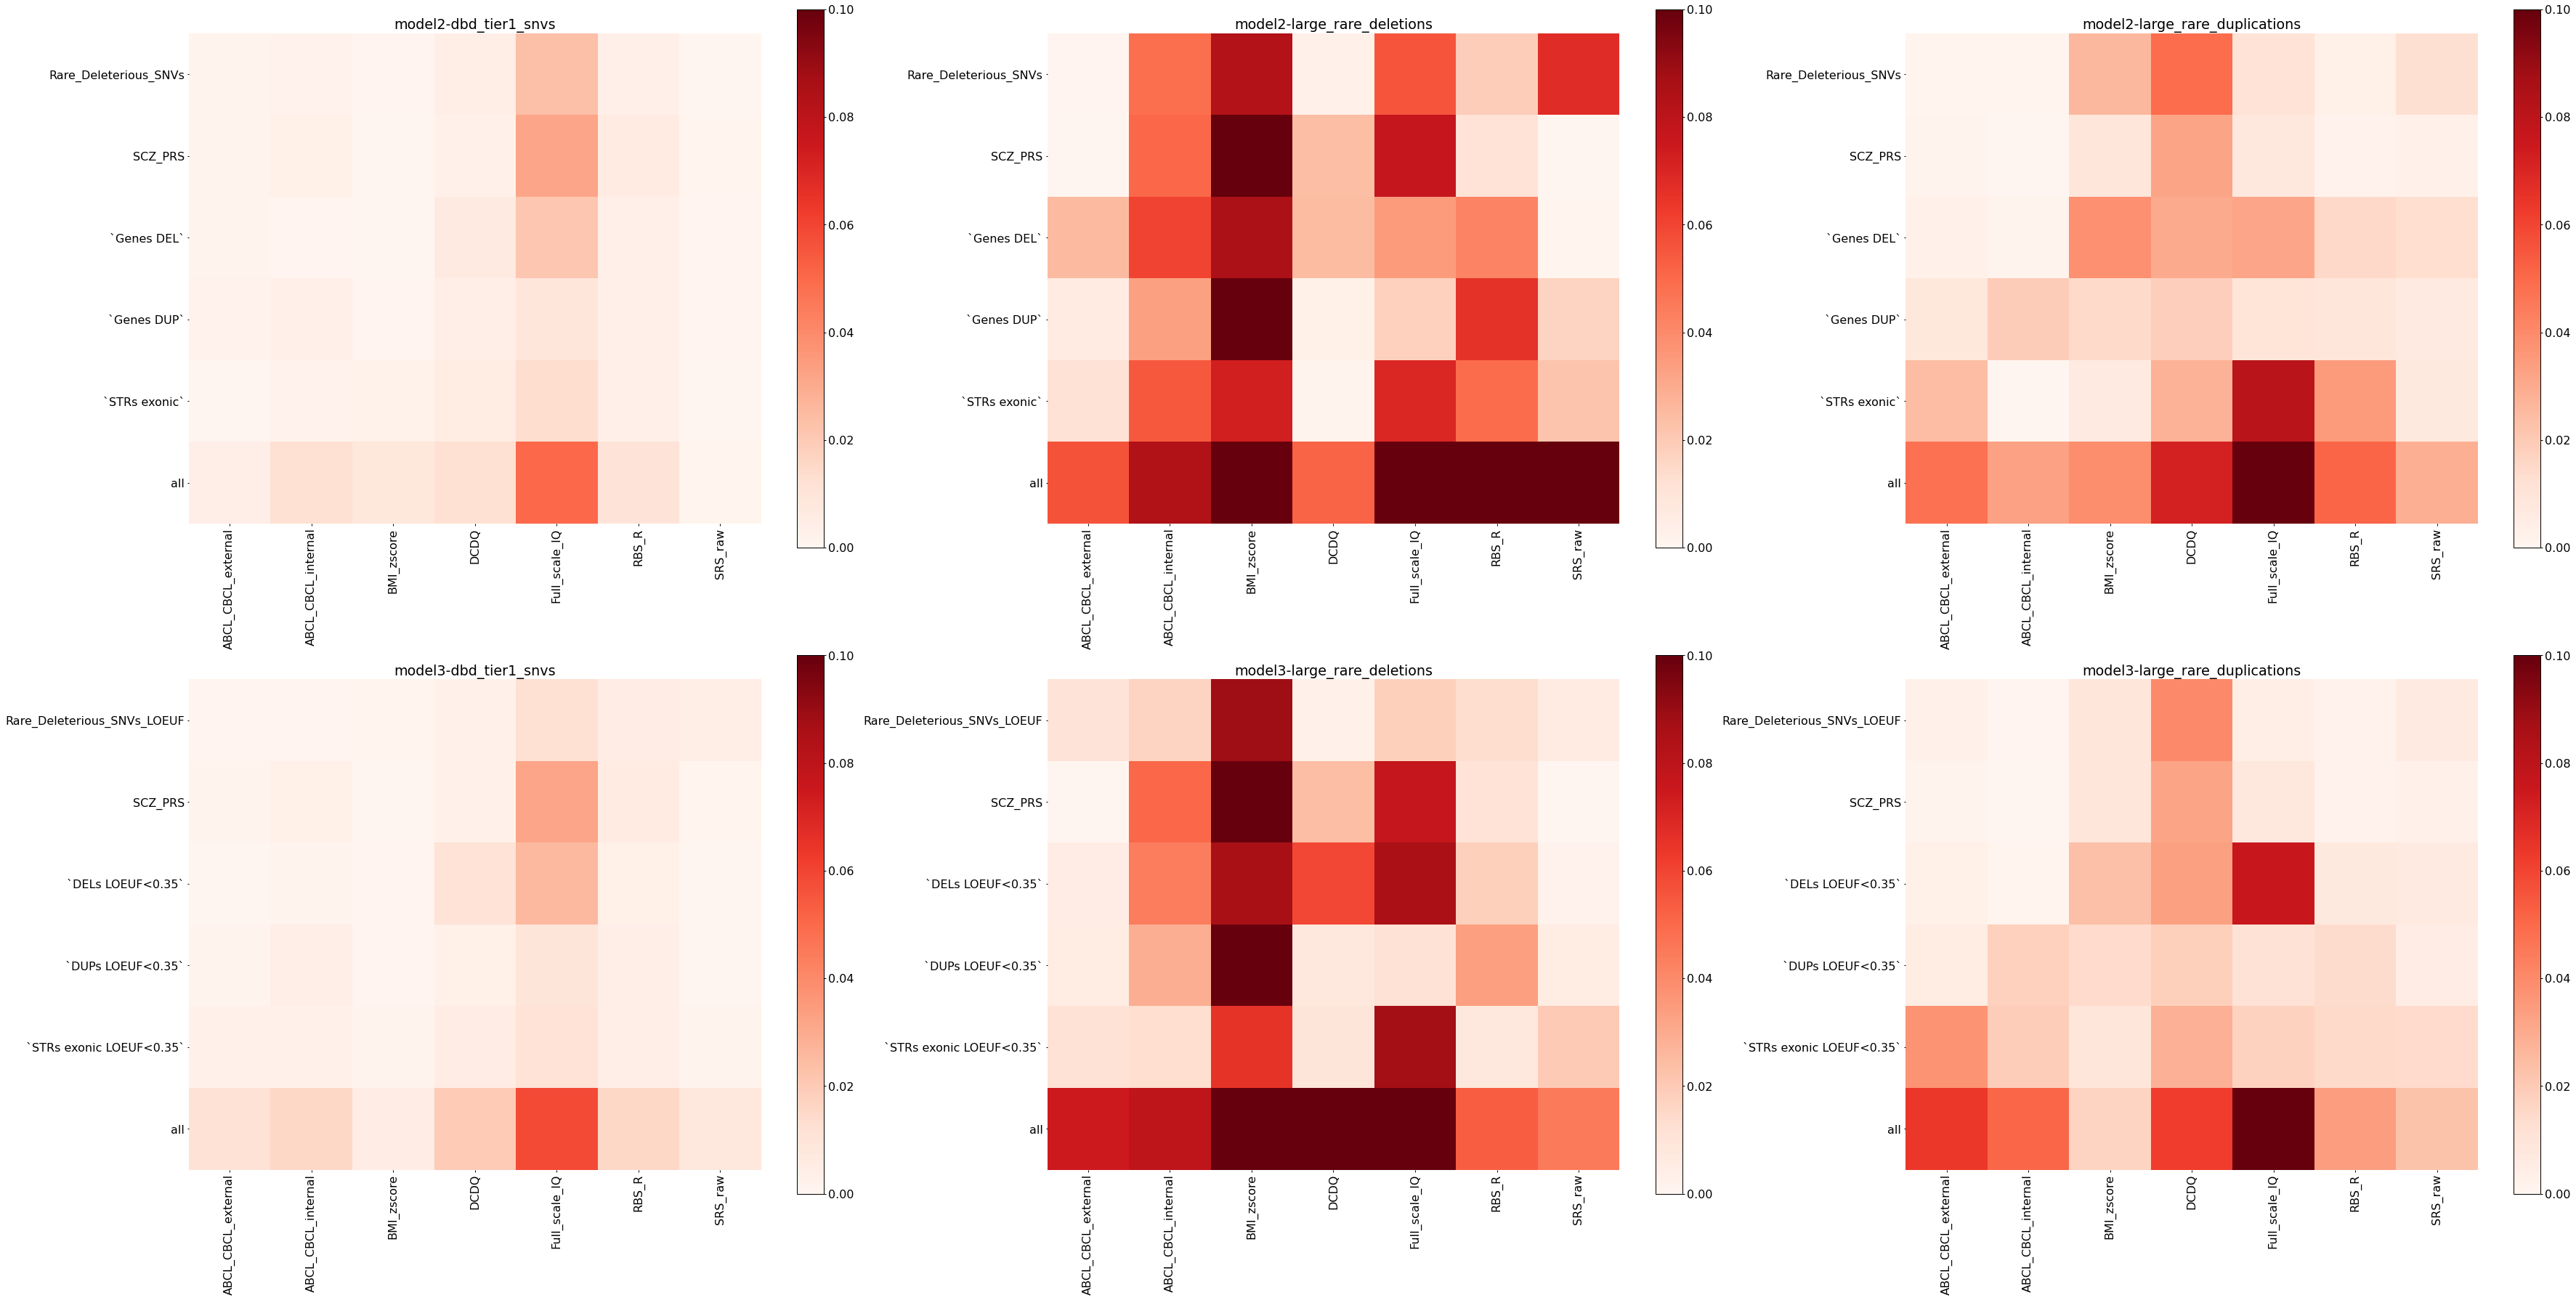

In [4]:
make_heatmaps("../data/statistics/", models[1:], sub_cohort[:3], pheno_cols, variables[1:], "../data/figures/model_heatmaps.pdf")

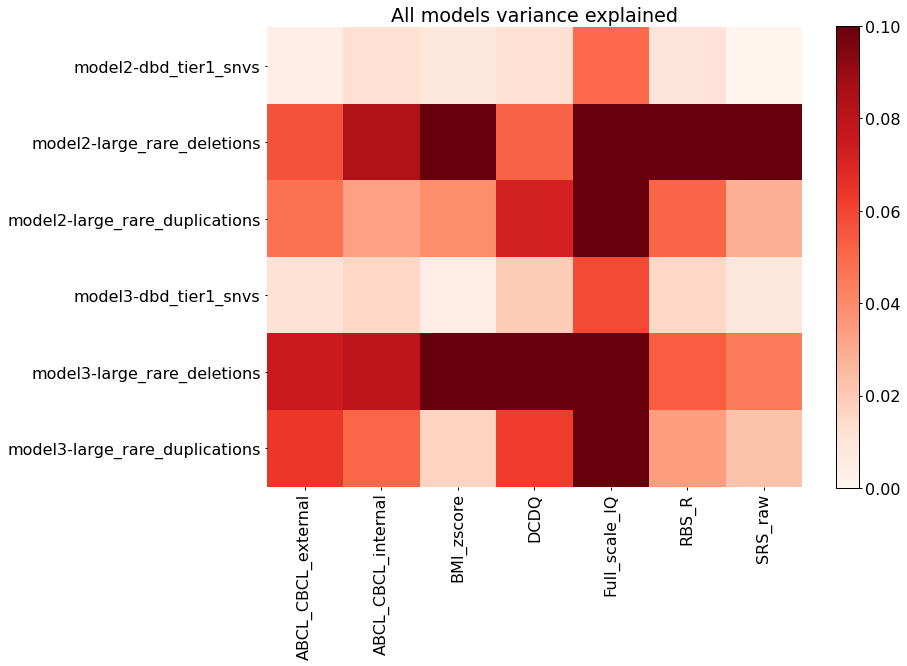

In [5]:
sa = make_heatmaps_all("../data/statistics/", models[1:], sub_cohort[:3], pheno_cols, "../data/figures/all_heatmaps.pdf")